In [3]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import pandas as pd
import os

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns
import datetime
from pathlib import Path
base_path = r'Z:/scratch/vr-foraging/data/'
data_path = r'../../../data/'


## Recover the session values to see if it matters

In [7]:
import math
def solve_quadratic(y, a, b, c):
    # Adjust c for y
    c -= y
    # Calculate the discriminant
    discriminant = b**2 - 4*a*c
    
    if discriminant < 0:
        return "No real solutions"
    elif discriminant == 0:
        # One solution
        x = -b / (2 * a)
        return [x]
    else:
        # Two solutions
        x1 = (-b + math.sqrt(discriminant)) / (2 * a)
        x2 = (-b - math.sqrt(discriminant)) / (2 * a)
        return [x1, x2]
    
# Define a quadratic model function to fit
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

In [ ]:
torque_readings = pd.DataFrame()
date = datetime.date.today()
date_string = "10/25/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [ ]:
for mouse in ['754570','754579','754567','754580','754559','754560','754577','754566','754570','754571','754572','754573','754574','754575', '754582','745302','745305','745301']:
    print(mouse)
    cum_torque = pd.DataFrame()

    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))

    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)

    # All this segment is to find the correct session without having the specific path
    for file_name in sorted_files:
        # Find specific session sorted by date
        session = file_name[-15:-7]
        if datetime.datetime.strptime(session, "%Y%m%d").date() < date:
            continue
            
        # Recover data streams
        session_path = os.path.join(base_path, mouse, file_name)
        session_path = Path(session_path)
        try:
            data = parse.load_session_data(session_path)
        except:
            continue
        
        rig_name = data['config'].streams.rig_input.data['rig_name']
        experiment = data['config'].streams.tasklogic_input.data['stage_name']
        
        if experiment != 'friction' and experiment != 'friction_15' and experiment != 'friction_optimized':
            continue
        # Parse data into a dataframe with the main features
        try:
            reward_sites, active_site, config = parse.parse_dataframe(data)
        except:
            continue
        
        # -- At this step you can save the data into a csv file
        
        # Expand with extra columns
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()
        
        if active_site.loc[active_site.label == 'InterPatch'].length.min() == 50:
            section = 'PostPatch'
        else:
            print(experiment)
            section = 'InterPatch'

        if section == 'PostPatch':
            active_site['active_patch'] = active_site['active_patch'].shift(-1)
            
        active_site['end_epoch'] = active_site.index.to_series().shift(-1)
        active_site['epoch_duration'] = active_site['end_epoch'] - active_site.index

        new_active_site = active_site[active_site['label'] == section]

        # Load the encoder data separately
        stream_data = parse.ContinuousData(data)
        torque_data = stream_data.torque_data
        brake_data = stream_data.brake_data
        
        velocity = plotting.trial_collection(new_active_site, 
                                                        torque_data, 
                                                        mouse, 
                                                        session, 
                                                        aligned='end_epoch',
                                                        window=[-2,2],  
                                                        taken_col=['Torque'])
        
        velocity['align'] = 'onset'
        velocity['experiment'] = experiment
        velocity['rig_name'] = rig_name
        
        if velocity.empty:
            print('No data for this mouse')
            continue
        
        torque_readings_temp = velocity.loc[(velocity.times >= 0) & (velocity.times <= 2)].groupby('experiment').Torque.mean().reset_index()
        torque_readings_temp['ON'] = 0
        torque_readings_temp['rig'] = rig_name
        torque_readings_temp['Brake'] = 0
        torque_readings_temp['mouse'] = mouse
        torque_readings = pd.concat([torque_readings, torque_readings_temp])

        torque_readings_temp = velocity.loc[(velocity.times >= -2) & (velocity.times <0)].groupby('experiment').Torque.mean().reset_index()
        torque_readings_temp['ON'] = 1
        torque_readings_temp['rig'] = rig_name
        torque_readings_temp['Brake'] = np.where(torque_readings_temp['ON'] == 1, brake_data.BrakeCurrentSetPoint.max(), 0)
        torque_readings_temp['mouse'] = mouse
        torque_readings = pd.concat([torque_readings, torque_readings_temp])

In [ ]:
brake_data = stream_data.brake_data

In [ ]:
torque_readings.to_csv(data_path + 'torque_readings.csv', index=False)

## Recover the calibration

In [4]:
path = r'Z:\scratch\vr-foraging\brake_calibratrion'

In [5]:
df_cum = pd.DataFrame()
for calibrations in os.listdir(path):
    df = pd.read_csv(os.path.join(path, calibrations), names=['input_torque', 'output_torque'])
    df['wheel'] = calibrations[:2]
    df_cum = pd.concat([df_cum, df], axis=0)

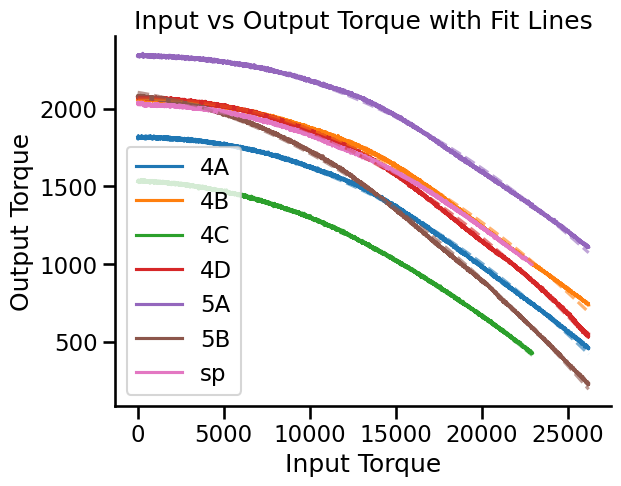

In [11]:
params_df = pd.DataFrame(columns=['wheel', 'a', 'b', 'c'])

# Assuming df_cum is your DataFrame
# Plot the original data
sns.lineplot(data=df_cum, x='input_torque', y='output_torque', hue='wheel')

# Fit the model to each wheel's data and plot the fit
for wheel, color in zip(df_cum['wheel'].unique(), sns.color_palette('tab10')):
    wheel_data = df_cum[df_cum['wheel'] == wheel]
    x_data = wheel_data['input_torque']
    y_data = wheel_data['output_torque']
    
    # Fit the model
    popt, _ = curve_fit(quadratic_model, x_data, y_data)
    
    # Generate x values for the fit line
    x_fit = np.linspace(x_data.min(), x_data.max(), 100)
    y_fit = quadratic_model(x_fit, *popt)
    
    # Plot the fit line
    plt.plot(x_fit, y_fit, linestyle='--', color=color, alpha=0.6) 
    
    # Add parameters to DataFrame
    new_row = pd.DataFrame({
        'wheel': [wheel],
        'a': [popt[0]],
        'b': [popt[1]],
        'c': [popt[2]]
    })
    params_df = pd.concat([params_df, new_row], ignore_index=True)
    
    # y = torque_readings.loc[(torque_readings.ON == 1)&(torque_readings.rig == wheel)&(torque_readings.experiment == 'friction')].Torque.mean()
    # x = torque_readings.loc[(torque_readings.ON == 1)&(torque_readings.rig == wheel)&(torque_readings.experiment == 'friction')].Brake.mean()
    # plt.plot(x, y, marker='X', color=color)
    
    # y = torque_readings.loc[(torque_readings.ON == 0)&(torque_readings.rig == wheel)].Torque.mean()
    # x = torque_readings.loc[(torque_readings.ON == 0)&(torque_readings.rig == wheel)].Brake.mean()
    # plt.plot(x, y, marker='X', color=color)
    
    # y = torque_readings.loc[(torque_readings.ON == 1)&(torque_readings.rig == wheel)&(torque_readings.experiment == 'friction_15')].Torque.mean()
    # x = torque_readings.loc[(torque_readings.ON == 1)&(torque_readings.rig == wheel)&(torque_readings.experiment == 'friction_15')].Brake.mean()
    # plt.plot(x, y, marker='X', color=color)
    
        
# Add legend and labels
plt.legend()
plt.xlabel('Input Torque')
plt.ylabel('Output Torque')
plt.title('Input vs Output Torque with Fit Lines')
sns.despine()
plt.show()

In [ ]:
collapsed = torque_readings.groupby(['experiment','rig', 'ON']).Torque.mean().reset_index()
collapsed['diff'] = abs(collapsed.Torque.shift(-1) - collapsed.Torque)
collapsed['fraction'] = (collapsed['diff'] / collapsed.Torque)*100
collapsed = collapsed.loc[collapsed.ON == 0]

In [16]:
for wheel in ['4A', '4B', '4C', '4D', '5A', '5B', 'sp']:
    y = params_df.loc[params_df.wheel == wheel].c.values[0] - params_df.loc[params_df.wheel == wheel].c.values[0] * 0.22
    brake = solve_quadratic(y, params_df.loc[params_df.wheel == wheel].a.values[0], params_df.loc[params_df.wheel == wheel].b.values[0], params_df.loc[params_df.wheel == wheel].c.values[0])
    print(wheel, "the value for the friction needs to be: ", brake[1] / 65535)

4A the value for the friction needs to be:  0.21399653773479482
4B the value for the friction needs to be:  0.23191159135290582
4C the value for the friction needs to be:  0.18247600557474508
4D the value for the friction needs to be:  0.21766662963635183
5A the value for the friction needs to be:  0.2595637653155037
5B the value for the friction needs to be:  0.16962169873760236
sp the value for the friction needs to be:  0.23052027756793603


In [ ]:
sns.scatterplot(data=collapsed, x='rig', y='Torque', hue='experiment')
sns.scatterplot(data=params_df, x='wheel', y='c', marker='X', s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
sns.scatterplot(data=collapsed, x='rig', y='fraction', hue='experiment')
# sns.scatterplot(data=params_df, x='wheel', y='Torque')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
print('Loading')
summary_df = pd.read_csv(os.path.join(data_path, 'batch_4.csv'), index_col=0)
summary_df['perceived_reward_probability'] = summary_df['cumulative_rewards'] / (summary_df['visit_number'] +1)
summary_df = summary_df[(summary_df['experiment'] == 'data_collection')|(summary_df['experiment'] == 'friction')|(summary_df['experiment'] == 'control')|(summary_df['experiment'] == 'distance_long')|(summary_df['experiment'] == 'distance_short')|(summary_df['experiment'] == 'friction_15')]
summary_df = summary_df[(summary_df['mouse'] != 754573)&(summary_df['mouse'] != 754572)]

In [ ]:
groups = ['within_session_number', 'session_number','mouse','active_patch','odor_label','experiment']

pre_df = summary_df[(summary_df['engaged'] == True)|(summary_df['active_patch'] <= 25)]
pre_df = pre_df.loc[pre_df.mouse != 754577]
# These df summarizes each patch for each session for each mouse
mouse_df = (
    pre_df.loc[(pre_df.visit_number > 0) & (pre_df.last_visit == 1)]
    .groupby(groups)
    .agg(
        visit_number=('visit_number', 'max'),
        reward_probability=('reward_probability', 'min'),
        stops=('visit_number', 'max'),
        total_rewards=('cumulative_rewards', 'max'),
        consecutive_rewards = ('consecutive_rewards', 'max'),
        total_failures=('cumulative_failures', 'max'),
        consecutive_failures = ('consecutive_failures', 'max')
    )
    .reset_index()
)
mouse_df['total_water'] = mouse_df['total_rewards']*5

# These df summarizes each session for each mouse (averages patches within session)
session_df = ( 
        mouse_df
        .groupby(['within_session_number', 'session_number','mouse','odor_label', 'experiment'])
        .agg({'visit_number':'sum', 
              'reward_probability':'mean', 
              'stops':'mean', 
              'total_rewards':'mean',
              'consecutive_rewards':'mean',
              'total_failures':'mean',
              'consecutive_failures':'mean', 
              'active_patch':'nunique', 
              'total_water':'sum'
              })
        .reset_index()
)

# These df summarizes metrics for each mouse (averages all sessions and all patches withing that session)
general_df = ( 
        mouse_df
        .groupby(['mouse','odor_label', 'experiment'])
        .agg({'visit_number':'mean', 
              'reward_probability':'mean', 
              'stops':'mean', 
              'total_rewards':'mean',
              'consecutive_rewards':'mean',
              'total_failures':'mean',
              'consecutive_failures':'mean', 
              'active_patch':'mean'
              })
        .reset_index()
)

In [ ]:
friction_exp = general_df.loc[(general_df.experiment == 'friction_15')|(general_df.experiment == 'control')].groupby(['mouse', 'experiment']).reward_probability.mean().reset_index()
friction_exp['diff'] = friction_exp.reward_probability.shift(-1) - friction_exp.reward_probability
friction_exp = friction_exp.loc[friction_exp.experiment == 'control']